In [1]:
# -*- coding: utf-8 -*-
"""
Application case of paper (Attention-based pattern discovery of mass spectrometry imaging data) code in prostate.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib inline
import numpy as np
np.random.seed(1337)
import torch
import torch.nn as nn
torch.manual_seed(1307)#为CPU设置随机种子 
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(1307)#为当前GPU设置随机种子 
import os
import h5py
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap
import time

# ========= Color Map ==============                                      
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


/home/amfe/anaconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # https://ms-imaging.org/wp-content/uploads/2009/08/specifications_imzML1.1.0_RC1.pdf 
# # imzML数据规范
# from pyimzml.ImzMLParser import ImzMLParser
# p = ImzMLParser('./data/3DMouseKidney.imzML') #需要将谱数据.ibd文件放在.imzml同目录下，否则会out of range

In [3]:
# #数据处理
# Spec_data =[]
# length=len(p.coordinates)
# mzArray=np.array(p.getspectrum(1000003))[0]#其实每列spectrum的mzarray都相同，这个1000003可以随便改
# print(mzArray.shape)
# for idx in range(0,length,10):
#     mzs, intensities = p.getspectrum(idx)
#     print(idx/length)
#     Spec_data.append(intensities)
# Spec_data=np.array(Spec_data)
# #print('Spec_data',Spec_data)
# print('Spec_data_size',Spec_data.shape)
# xlocation=np.array(p.coordinates)[:,0]
# xlocation=xlocation[0:length:10]#为了缩小数据规模，原来数据三十几个G，这里缩小到1/100，下方同理
# print(xlocation.shape)
# ylocation=np.array(p.coordinates)[:,1]
# ylocation=ylocation[0:length:10]
# print(ylocation.shape)

In [4]:

# myHF=h5py.File('./data/3DMouseKidney.h5','w')
# myHF.create_dataset('mzArray', data=mzArray)
# myHF.create_dataset('xlocation', data=xlocation)
# myHF.create_dataset('ylocation', data=ylocation)
# myHF.create_dataset('Data', data=Spec_data)
# # myHF. create_dataset('xLocation', data=XCoord)
# myHF.close()

In [5]:

# f =  h5py.File('./data/msiPL_Dataset/Prostate/P_1900.h5','r')  
# MSI_train = np.array(f["Data"])  # spectral information.
# All_mz = np.array(f["mzArray"] )
# nSpecFeatures = len(All_mz)
# if MSI_train.shape[1] != nSpecFeatures:
#     MSI_train = np.transpose(MSI_train)
# tic_sum=np.sum(MSI_train,axis=-1)[:,None]
# MSI_train=MSI_train/tic_sum
# xLocation = np.array(f["xLocation"]).astype(int)
# yLocation = np.array(f["yLocation"]).astype(int)
# col = max(np.unique(xLocation))
# row = max(np.unique(yLocation))
# im = np.zeros((col,row))
# mzId = np.argmin(np.abs(All_mz[:] - 2509.6))
# f.close()
# #MSI sample数 * mz宽度数

# # 找mz值接近于6227.9的时候，用所有数据坐标和强度绘图
# for i in range(len(xLocation)):
#     im[ xLocation[i].item()-1, yLocation[i].item()-1] = MSI_train[i,mzId] #image index starts at 0 not 1
# plt.imshow(im);plt.colorbar();plt.title('MouseKidney when m/z=2509.6')
# plt.show()
# MSI_im=np.zeros(shape=(len(All_mz),col,row),dtype=np.float16)
# for piece in range(len(All_mz)):
#     print("Piece",piece,'maID',All_mz[piece])
#     for index in range(len(xLocation)):
#         MSI_im[piece,xLocation[index].item()-1,yLocation[index].item()-1]=MSI_train[index,piece]
# ax=plt.subplot(1,2,1)
# plt.imshow(im);plt.colorbar()
# ax=plt.subplot(1,2,2)
# plt.imshow(MSI_im[mzId]);plt.colorbar()

In [2]:

# The data are publicly available, see our paper for details
f = h5py.File('./data/msiPL_Dataset/Prostate/P_1900.h5', 'r')
MSI_train = np.array(f["Data"])  # spectral information.
All_mz = np.array(f["mzArray"] )
nSpecFeatures = len(All_mz)
if MSI_train.shape[1] != nSpecFeatures:
    MSI_train = np.transpose(MSI_train)
tic_sum=np.sum(MSI_train,axis=-1)[:,None]
MSI_train=MSI_train/tic_sum
xLocation = np.array(f["xLocation"]).astype(int)-1
yLocation = np.array(f["yLocation"]).astype(int)-1
col = max(np.unique(xLocation))+1
row = max(np.unique(yLocation))+1
im = np.zeros((col,row))
mzId = np.argmin(np.abs(All_mz[:] - 2509.6))
f.close()
#MSI sample数 * mz宽度数

# 找mz值接近于6227.9的时候，用所有数据坐标和强度绘图
for i in range(len(xLocation)):
    im[ xLocation[i].item()-1, yLocation[i].item()-1] = MSI_train[i,mzId] #image index starts at 0 not 1
# plt.imshow(im);plt.colorbar();plt.title(f'm/z={All_mz[mzId]}')
plt.show()

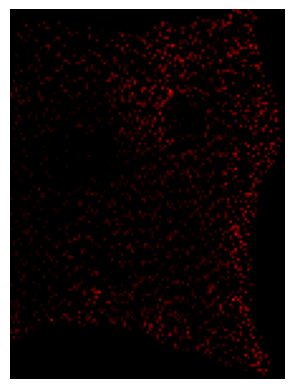

In [108]:
import matplotlib.colors as colors
im = np.zeros((col,row))
mzId = np.argmin(np.abs(All_mz[:] - 12000.6))
cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', [(0, 0, 0), (1, 0, 0)], N=256)
# 找mz值接近于6227.9的时候，用所有数据坐标和强度绘图
for i in range(len(xLocation)):
    im[ xLocation[i].item()-1, yLocation[i].item()-1] = MSI_train[i,mzId] #image index starts at 0 not 1
plt.imshow(im,cmap=cmap)

plt.grid(color=[0,0,0], linestyle='-', linewidth=0.5)
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
# plt.colorbar();plt.title(f'm/z={All_mz[mzId]}')
plt.show()

(-0.5, 108.5, 146.5, -0.5)

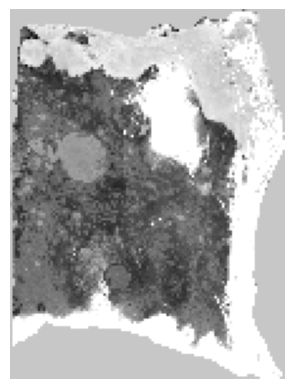

In [139]:
cmap = colors.LinearSegmentedColormap.from_list('custom_cmap', [(0, 0, 0), (1, 1, 1)], N=256)
ndim = d_model
im=np.zeros(shape=(col,row))
j=100
for i in range(0,len(xLocation)):
    im[ xLocation[i], yLocation[i]] = min(1,Latent_z[i,j])  
ax.grid(True, color='white', linewidth=0.5)
plt.imshow(im,cmap=cmap);  # plt.colorbar()   
plt.axis(False)

In [ ]:
from torch.autograd import Variable
from torch.utils.data import Dataset
import math
import torch.optim as optim
MSI_train=torch.tensor(MSI_train,dtype=torch.float32)
xLocation=torch.tensor(xLocation)
yLocation=torch.tensor(yLocation)

class MSIdataset(Dataset):
    def __init__(self, data,xLoc,yLoc):
        self.len = len(data)
        self.data = data
        self.xLoc=xLoc
        self.yLoc=yLoc
    def __getitem__(self, index):
        return self.data[index],self.xLoc[index],self.yLoc[index]
    def __len__(self):
        return self.len
class Atnal_model(nn.Module):
    def __init__(self,batchsize,d_mz,d_model=256,encoder_layer_num=7,n_head=8,device='cpu'):
        super().__init__() 
        self.backbone=nn.Sequential(nn.Linear(d_mz,512,device=device),nn.BatchNorm1d(num_features=512,momentum=0.99,eps=1e-3),nn.ReLU(),\
                                    nn.Linear(512,d_model,device=device),nn.BatchNorm1d(num_features=d_model,momentum=0.99,eps=1e-3))
        #self.transformer=nn.Transformer(d_model,n_head,encoder_layer_num,decoder_layer_num,device=device)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head)
        self.transformerencoder=nn.TransformerEncoder(encoder_layer=encoder_layer,num_layers=encoder_layer_num)
        # self.row=nn.parameter(torch.rand(batch_size//2,d_model//2))
        # self.col=nn.parameter(torch.rand(batch_size//2,d_model//2))
        # self.recover=nn.Sequential(nn.Linear(d_model,1024),nn.BatchNorm1d(num_features=1024),nn.ReLU(),nn.Linear(1024,d_mz),nn.Sigmoid())
        self.recover=nn.Sequential(nn.Linear(d_model,512),nn.BatchNorm1d(num_features=512,momentum=0.99,eps=1e-3),\
                                   nn.ReLU(),nn.Linear(512,d_mz),nn.Softmax())
        self.d_model=d_model
        self.position_Enbedding=torch.zeros([batchsize,d_model])
        self.loss=[]

    def forward(self,input,xLocation,yLocation):
        h=self.backbone(input)
        #if self.position_Enbedding==None:
        #position_Enbedding=PositionalEncoding2d(d_model=self.d_model,xLocation= xLocation,yLocation=yLocation)
        transformer_input=h
        #transformer_input=h
        # #print(transformer_input.shape)
        # #print(self.query_pos.shape)
        h=self.transformerencoder(transformer_input)
        return  self.recover(h)
    # def TIC_norm(self,input):
    #     return input/torch.sum(input,dim=-1)[:,None]
def categorical_crossentropy(pred, label):
    """
    使用pytorch 来实现 categorical_crossentropy
    """
    # print(-label * torch.log(pred))
    #print(-label * torch.log(pred))
    #pred=pred/(pred.sum(-1).reshape(-1,1))
    pred=torch.clip(pred,min=1e-7,max=1.-1e-7)
    loss=(torch.sum(-label * torch.log(pred)))/pred.shape[0]
    
    # return nn.Sigmoid()(loss)
    # loss = nn.BCELoss()(pred, label)
    #loss=nn.CrossEntropyLoss(pred,label)
    return loss

batchsize=256
epochs=20
lr=1e-4
d_model=256
device=torch.device('cuda')
All_dataset=MSIdataset(MSI_train,xLocation,yLocation)
dataloader = torch.utils.data.DataLoader(All_dataset, batch_size=batchsize,
                                          shuffle=True, num_workers=8)
loss_function=categorical_crossentropy
Atn_model = Atnal_model(batchsize=batchsize, d_mz=len(
    All_mz), d_model=d_model, encoder_layer_num=1)
Atn_model.load_state_dict(torch.load('TrainedModel_prostate_trans.h5'))
Atn_model = Atn_model.to(device)
optimizer = optim.Adam(Atn_model.parameters(), lr=lr, weight_decay=0.01)
if True:
    for epoch in range(epochs):
        time1=time.time()
        loss_in_epoch=[]
        Atn_model.train()
        for i,(data,xLoc,yLoc) in enumerate(dataloader):
            data=data.to(device)
            loss=loss_function(detr(data,xLoc,yLoc),data)
            #print(f'Epoch: {epoch} step: {i} loss:{loss.item()}')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_in_epoch.append(loss.item())
        time2=time.time()
        Atn_model.loss.append(np.mean(loss_in_epoch))
        print(f'avg loss in epoch {epoch}:{np.mean(loss_in_epoch)} Time/epoch:{(time2-time1)}s')
        if epoch%40==0:
            torch.save(detr.state_dict(),'TrainedModel_prostate_trans.h5')
Atn_model.eval()
Atn_model.to('cpu')
plt.plot(np.arange(epochs), Atn_model.loss, lw=4)
# plt.xlabel('Epoch');plt.ylabel('Loss')
# plt.legend()
plt.show()
torch.save(Atn_model.state_dict(), 'TrainedModel_prostate_trans.h5')

[]

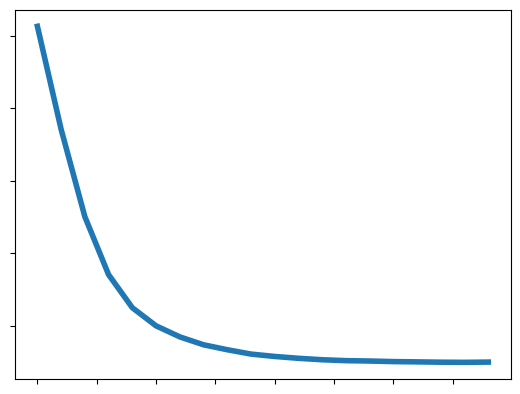

In [31]:
plt.plot(np.arange(epochs),detr.loss,lw=4);
ax = plt.gca()

ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

/home/amfe/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


mean squared error(mse)  =  tensor(8.2887e-09)


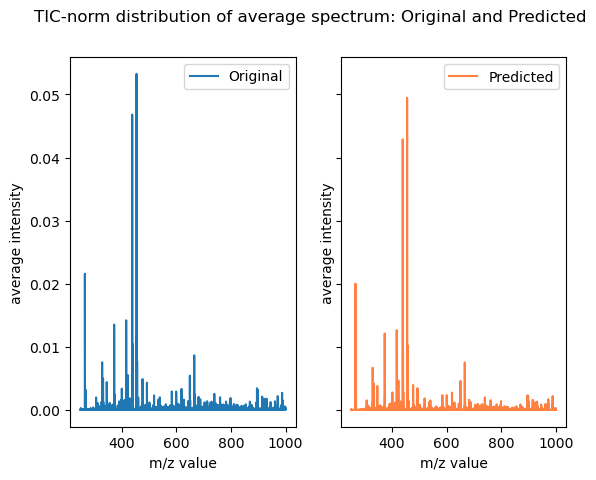

In [6]:
with torch.no_grad():
    #Encoder=nn.Sequential(detr.backbone,detr.transformer.encoder)
    decoded_imgs = Atn_model(MSI_train,xLocation,yLocation) # Learned non-linear manifold
    #encoded_imgs = Encoder(MSI_train) # Reconstructed Data
    dec_TIC = torch.sum(decoded_imgs, axis=-1)
    #encoded_result=Encoder(MSI_train)
    %matplotlib inline

    mse = nn.MSELoss()(MSI_train,decoded_imgs)
    meanSpec_Rec = torch.mean(decoded_imgs,axis=0) 
    print('mean squared error(mse)  = ', mse)
    meanSpec_Orig = torch.mean(MSI_train,axis=0) # TIC-norm original MSI Data
    N_DecImg = decoded_imgs/dec_TIC[:,None]  # TIC-norm reconstructed MSI  Data
    meanSpec_RecTIC = torch.mean(N_DecImg,axis=0)
    fig,axes=plt.subplots(nrows=1,ncols=2,sharey=True)
    plt.suptitle('TIC-norm distribution of average spectrum: Original and Predicted')
    axes[0].set_xlabel('m/z value');axes[0].set_ylabel('average intensity');
    axes[1].set_xlabel('m/z value');axes[1].set_ylabel('average intensity')
    axes[0].plot(All_mz,meanSpec_Orig.detach().numpy(),label='Original'); 
    axes[0].legend()
    axes[1].plot(All_mz,meanSpec_RecTIC.detach().numpy(),color = [1.0, 0.5, 0.25],label='Predicted'); 
    axes[1].legend()
    plt.savefig('achemso/pic/prostate/ori_pre.png',bbox_inches='tight',dpi=1000)  

(212.50490493774413,
 1037.4309013366699,
 -0.0026603912792451424,
 0.05590942785652686)

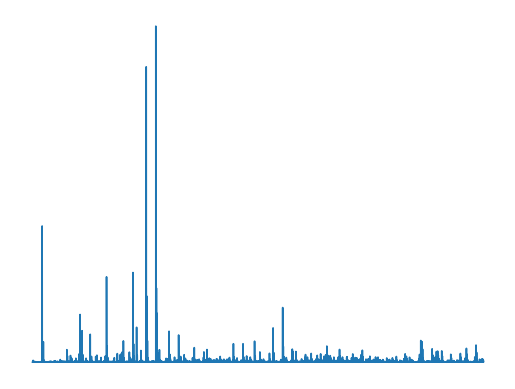

In [15]:
plt.plot(All_mz,MSI_train.mean(axis=0),linewidth=1.2)
plt.axis(False)

(212.50490493774413,
 1037.4309013366699,
 -0.054592625424265864,
 0.05838239304721356)

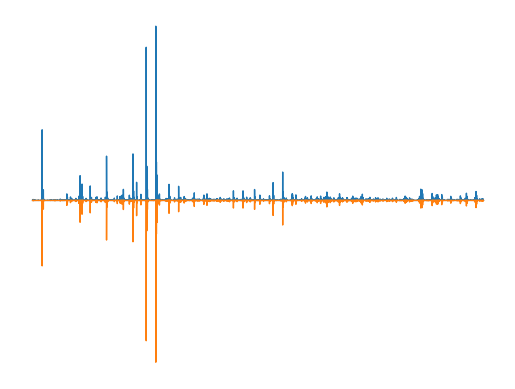

In [42]:
plt.plot(All_mz,meanSpec_Orig.detach().numpy(),linewidth=1)
plt.plot(All_mz,-meanSpec_RecTIC.detach().numpy(),linewidth=1)
plt.axis(False)
#plt.savefig('Template/pic/prostate/ori_pre.png',bbox_inches='tight',dpi=1000)  

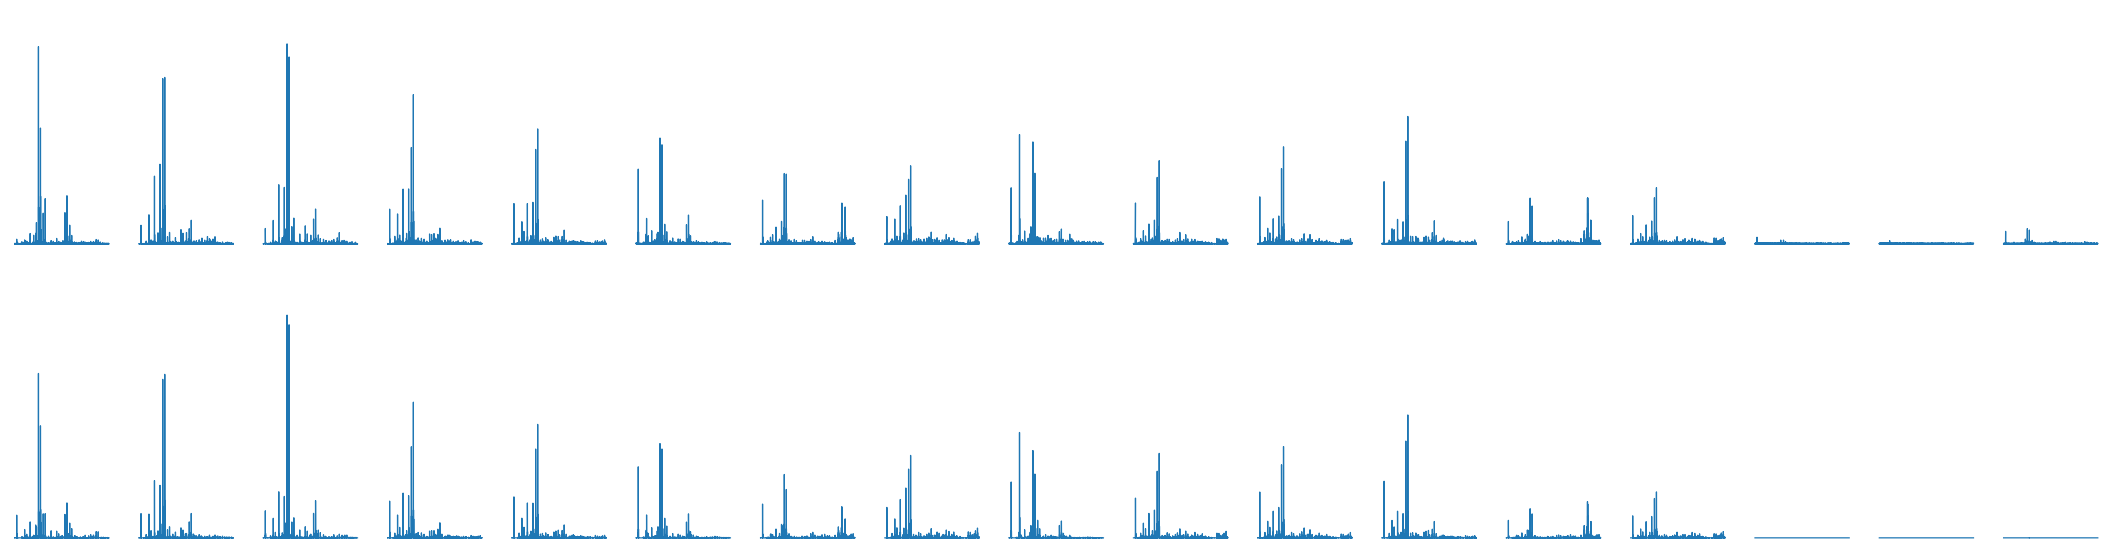

In [21]:
index=[0,500,1000,1500,2000,2500,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,12699]
fig,axes=plt.subplots(nrows=2,ncols=len(index),sharey=True,figsize=(27, 7))
for id,num in enumerate(index):
    axes[0,id].plot(All_mz,MSI_train[num],linewidth=0.9)
    if id!=0:
        axes[0,id].set_yticks([])
    axes[0,id].set_xticks([])
    axes[0,id].spines['top'].set_visible(False)
    axes[0,id].spines['right'].set_visible(False)
    axes[0,id].spines['bottom'].set_visible(False)
    axes[0,id].spines['left'].set_visible(False)
for id,num in enumerate(index):
    axes[1,id].plot(All_mz,decoded_imgs[num].detach().numpy(),linewidth=0.9)
    if id!=0:
        axes[1,id].set_yticks([])
    axes[1,id].set_xticks([])
    axes[1,id].spines['top'].set_visible(False)
    axes[1,id].spines['right'].set_visible(False)
    axes[1,id].spines['bottom'].set_visible(False)
    axes[1,id].spines['left'].set_visible(False)

In [ ]:
# MSI_train=torch.tensor(MSI_train,dtype=torch.float32)
# xLocation=torch.tensor(xLocation)
# yLocation=torch.tensor(yLocation)

In [17]:

encoder=nn.Sequential(detr.backbone,detr.transformerencoder)
encoder.eval()
Latent_z=encoder(MSI_train).detach().numpy()
MSI_train=MSI_train.detach().numpy()
xLocation=xLocation.detach().numpy()
yLocation=yLocation.detach().numpy()




(-0.5, 108.5, 146.5, -0.5)

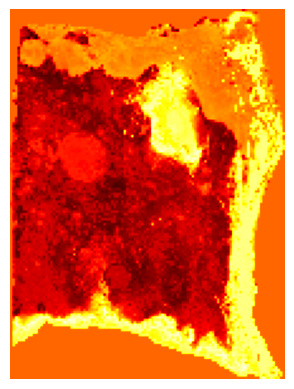

In [27]:
ndim = d_model
im=np.zeros(shape=(col,row))
j=100
for i in range(len(xLocation)):
    im[ xLocation[i], yLocation[i]] = Latent_z[i,j]  

plt.imshow(im,cmap="hot");  # plt.colorbar()   
plt.axis(False)

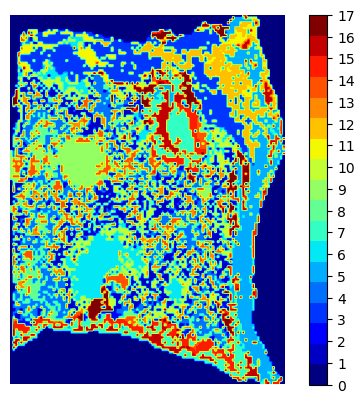

In [114]:
from sklearn.mixture import GaussianMixture
#n_clusters=(kneedle_point.knee)
n_clusters=17
gmm=GaussianMixture(n_components=n_clusters,covariance_type='full',random_state=0).fit(Latent_z)
labels = gmm.predict(Latent_z)
labels+=1
im=np.full(shape=(col,row),fill_value=0)
for i in range(len(xLocation)):
    im[ xLocation[i], yLocation[i]] = labels[i]
MyCmap = discrete_cmap(n_clusters+1, 'jet')
plt.imshow(im,cmap=MyCmap);
plt.colorbar(ticks=np.arange(0,n_clusters+1,1))
plt.axis('off')
plt.savefig('achemso/pic/prostate/gmm_all.png',bbox_inches='tight',dpi=100)

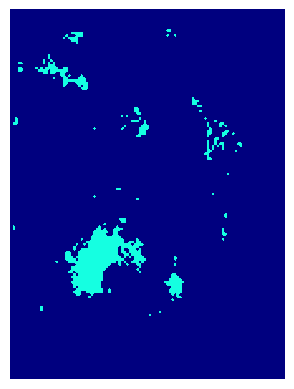

In [89]:
cluster_id = 6
im=np.full(shape=(col,row),fill_value=0)
Kimg = labels==cluster_id
Kimg = Kimg.astype(int)

for i in range(len(xLocation)):
    im[ xLocation[i], yLocation[i]] = Kimg[i]
segCmp = [MyCmap(0),MyCmap(cluster_id)]
cm = LinearSegmentedColormap.from_list('Walid_cmp',segCmp,N=2)
plt.imshow(im, cmap=cm);
plt.axis('off')
plt.savefig('achemso/pic/prostate/gmm_selected.png',bbox_inches='tight',dpi=100)

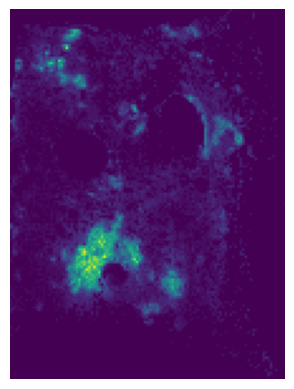

m/z 774.59827
corr_Value =  0.792685074351647
['774.5983', '775.6025', '884.5723', '845.6712', '760.5827', '761.5867', '253.5388', '762.5862', '504.3485', '380.3034']
Correlation Top 10 Ranked peaks:['0.7927', '0.7781', '0.7637', '0.7615', '0.7567', '0.7530', '0.7495', '0.7448', '0.7376', '0.7375']


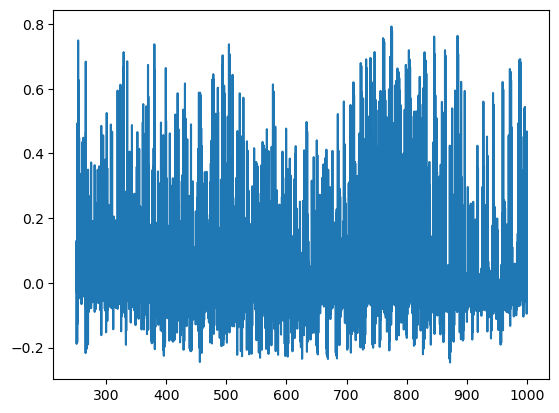

In [61]:
%matplotlib inline
import scipy.stats as stats
Corr_Val =  np.zeros(len(All_mz))
for i in range(len(All_mz)):
    Corr_Val[i] = stats.pearsonr(Kimg,MSI_train[:,i])[0]#Kimg(聚类的结果labels,size=sample_num*1)和MSI_PeakList(size=sample_num*选出的peak数)
    #所以计算出的Corr_Val size=选出的peak数*1,记录的是每个peak与聚类结果的皮尔森相关系数
id_mzCorr = np.argmax(Corr_Val)#选个相关系数最大的peak，记下其下标
rank_ij =  np.argsort(Corr_Val)[::-1]

im = np.zeros((col,row))

for i in range(len(xLocation)):
    im[ xLocation[i].item()-1, yLocation[i].item()-1] = MSI_train[i,id_mzCorr].item()  
plt.imshow(im)
plt.axis('off')
plt.show()
print('m/z', All_mz[id_mzCorr])
print('corr_Value = ', Corr_Val[id_mzCorr])

plt.plot(All_mz,Corr_Val)
print(['%0.4f' % i for i in All_mz[rank_ij[0:10]]])
print('Correlation Top 10 Ranked peaks:', end='') 
print(['%0.4f' % i for i in Corr_Val[rank_ij[0:10]]])

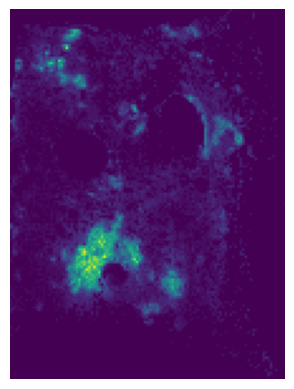

m/z 774.59827
corr_Value =  0.7615947366156929
['774.5983', '884.5723', '845.6712', '775.6025', '760.5827', '761.5867', '829.6375', '863.6799', '803.6224', '504.3485', '846.6770', '762.5862', '864.6829', '253.5388', '804.6077']
Correlation Top 10 Ranked peaks:['0.7616', '0.7595', '0.7504', '0.7462', '0.7191', '0.7166', '0.7137', '0.7132', '0.7095', '0.7083', '0.7062', '0.7046', '0.6960', '0.6936', '0.6890']


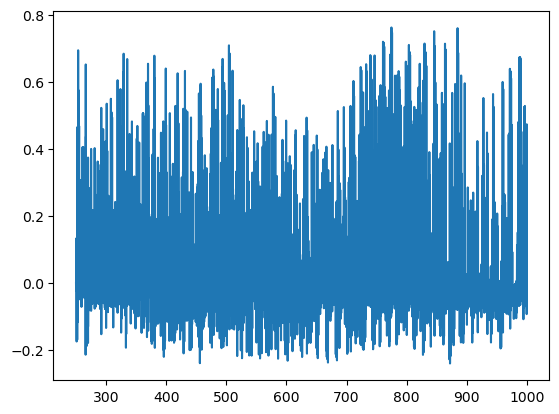

In [85]:
im = np.zeros((col,row))

for i in range(len(xLocation)):
    im[ xLocation[i].item()-1, yLocation[i].item()-1] = MSI_train[i,id_mzCorr].item()  
plt.imshow(im)
plt.axis('off')
plt.show()
print('m/z', All_mz[id_mzCorr])
print('corr_Value = ', Corr_Val[id_mzCorr])

plt.plot(All_mz,Corr_Val)
print(['%0.4f' % i for i in All_mz[rank_ij[0:15]]])
print('Correlation Top 10 Ranked peaks:', end='') 
print(['%0.4f' % i for i in Corr_Val[rank_ij[0:15]]])